In [64]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torch.optim import SGD
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from engine import train_one_epoch, evaluate

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import json
import PIL.Image
from matplotlib import pyplot as plt
#train the models on the big dataset with all classes and single faces
import numpy as np
import os
import torch
import time




In [47]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_training(models):
    num_models = len(models)
    num_metrics = 3  # ap_values, ar_values, losses
    fig, axes = plt.subplots(num_metrics, num_models, figsize=(num_models * 6, num_metrics * 4))
    
    metrics_labels = ["0.50:0.95", "0.50", "0.75", "0.50:0.95_small", "0.50:0.95_medium", "0.50:0.95_large"]
    
    for i, model in enumerate(models):
        ap_values = model['ap_values']
        ar_values = model['ar_values']
        losses = model['losses']
        
        # Plot AP values
        ax = axes[0, i]
        for j in range(6):
            ax.plot(ap_values[:, j], label=metrics_labels[j])
        ax.set_title(f"{model['name']} - AP Values")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("AP Value")
        ax.legend()
        
        # Plot AR values
        ax = axes[1, i]
        for j in range(6):
            ax.plot(ar_values[:, j], label=metrics_labels[j])
        ax.set_title(f"{model['name']} - AR Values")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("AR Value")
        ax.legend()
        
        # Plot losses
        ax = axes[2, i]
        ax.plot(losses, label=model['name'])
        ax.set_title(f"{model['name']} - Losses")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


In [48]:
import os
import numpy as np

def read_metrics_from_folder(folder_path):
    models = []
    
    scenario_folders = os.listdir(folder_path)
    
    for scenario_folder in scenario_folders:
        scenario_path = os.path.join(folder_path, scenario_folder)
        metrics_folder = os.path.join(scenario_path, "metric_history")
        
        if not os.path.exists(metrics_folder):
            continue
        
        model_files = os.listdir(metrics_folder)
        
        for model_file in model_files:
            model_path = os.path.join(metrics_folder, model_file)
            model_name = os.path.splitext(model_file)[0]
            metrics_data = np.load(model_path)
            
            model = {
                'name': model_name,
                'ap_values': metrics_data['ap_values'],
                'ar_values': metrics_data['ar_values'],
                'losses': metrics_data['losses']
            }
            
            models.append(model)
    
    return models

In [49]:
folder_path = 'finished_models'
models = read_metrics_from_folder(folder_path)
models

[{'name': 'mobile_all_classes_metrics',
  'ap_values': array([[0.1228441 , 0.24763368, 0.10640046, 0.02242295, 0.10719587,
          0.17471084],
         [0.20036858, 0.37124503, 0.19292099, 0.04256519, 0.16185624,
          0.28400078],
         [0.24355884, 0.43758619, 0.24421404, 0.05529134, 0.21256297,
          0.3314719 ],
         [0.2660038 , 0.47619169, 0.26518195, 0.06064166, 0.21832054,
          0.36315368],
         [0.28098045, 0.5023755 , 0.28527192, 0.0581133 , 0.22387061,
          0.38143624],
         [0.28683534, 0.51343866, 0.28955526, 0.05538206, 0.23237077,
          0.39340194],
         [0.29236887, 0.51847761, 0.30082899, 0.04827655, 0.23262445,
          0.40824764],
         [0.29959306, 0.52652094, 0.31005175, 0.05777074, 0.23833579,
          0.41169821],
         [0.30019786, 0.53798116, 0.30649486, 0.06028549, 0.22809939,
          0.41601425],
         [0.30161165, 0.52047492, 0.31617608, 0.06337423, 0.23177253,
          0.41352978]]),
  'ar_values': 

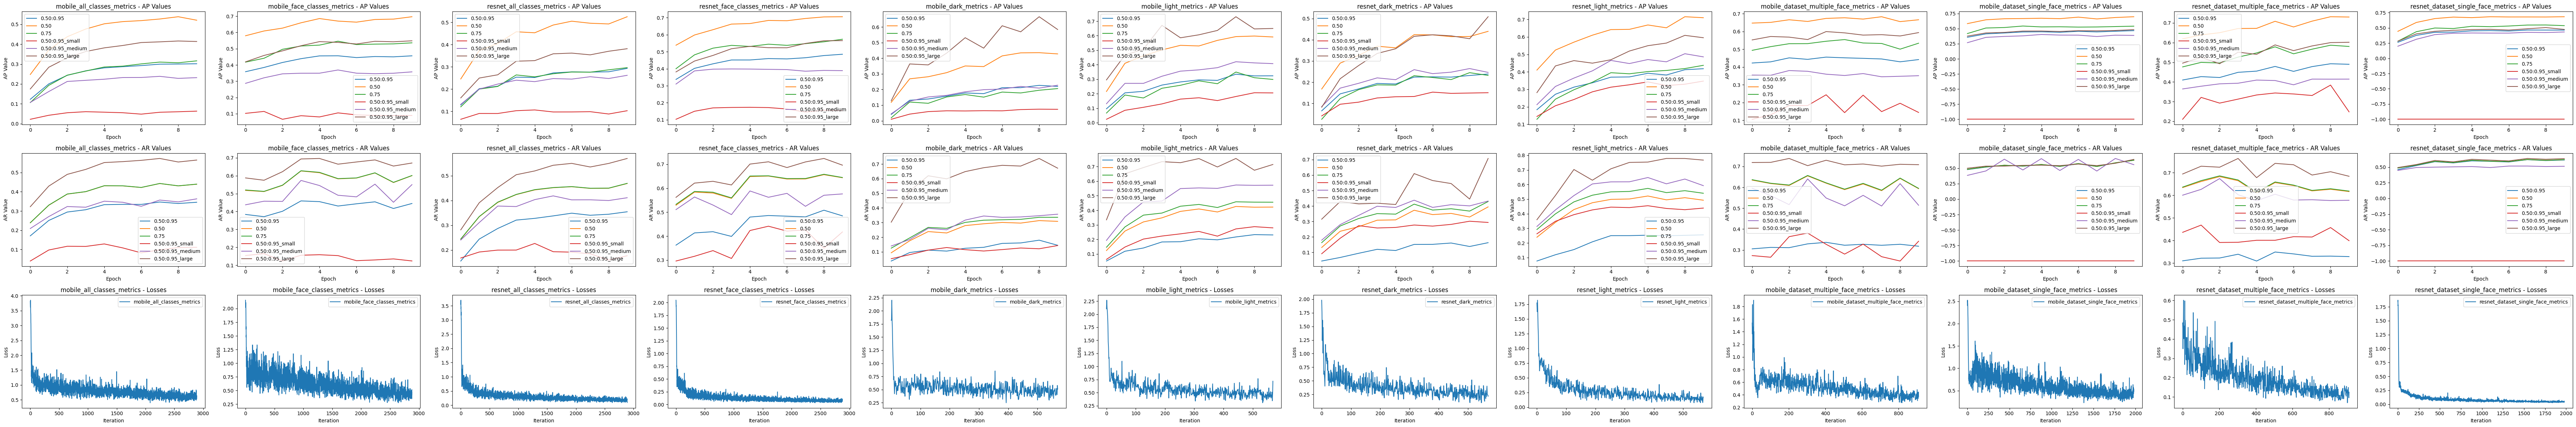

In [50]:
visualize_training(models)

In [51]:
import os
import pickle

def load_dataloaders():
    load_folder = "dataloaders"
    dataloaders = {}
    dataloaders_light = {}
    dataloaders_crowds = {}

    def load_dataloader_dict(dataloader_dict, dict_name):
        dict_folder = os.path.join(load_folder, dict_name)

        for dataset_name in os.listdir(dict_folder):
            dataset_folder = os.path.join(dict_folder, dataset_name)

            if not os.path.isdir(dataset_folder):
                continue

            dataset_loaders = {}
            for split_name in os.listdir(dataset_folder):
                split_folder = os.path.join(dataset_folder, split_name)

                if not os.path.isdir(split_folder):
                    continue

                load_path = os.path.join(split_folder, "dataloader.pkl")
                with open(load_path, "rb") as f:
                    dataset_loaders[split_name] = pickle.load(f)

            dataloader_dict[dataset_name] = dataset_loaders

    load_dataloader_dict(dataloaders, "dataloaders")
    load_dataloader_dict(dataloaders_light, "dataloaders_light")
    load_dataloader_dict(dataloaders_crowds, "dataloaders_crowds")

    return dataloaders, dataloaders_light, dataloaders_crowds

In [52]:
dataloaders, dataloaders_light, dataloaders_crowds = load_dataloaders()

In [85]:
import os
import torch

def load_models(model_folder):
    models = {}

    if not os.path.exists(model_folder) or not os.path.isdir(model_folder):
        return models

    for folder_name in os.listdir(model_folder):
        print("---------------------------------")
        print("loading folder:", folder_name, "...")

        folder_path = os.path.join(model_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue

        model_dict = {}
        for file_name in os.listdir(folder_path):

            if file_name.endswith('.pth'):
                model_name = os.path.splitext(file_name)[0]
                print("loading model:", model_name, "...")
                model_path = os.path.join(folder_path, file_name)
                model = torch.load(model_path)

                #if the model name has all_classes 
                if model_name.endswith('all_classes'):
                    num_classes = 21

                #if model name contains dark or light
                elif model_name.endswith('dark') or model_name.endswith('light'):
                    num_classes = 4

                #if the model name ends wirth multiple_face or single_face
                elif model_name.endswith('multiple_face') or model_name.endswith('single_face') or model_name.endswith('face_classes'):
                    num_classes = 5

                else:
                    raise Exception("Unknown model name")
                
                #check if the model name starts with resnet or mobile
                if model_name.startswith('resnet'):
                    empty_model = fasterrcnn_resnet50_fpn(pretrained=True)
                    in_features = empty_model.roi_heads.box_predictor.cls_score.in_features
                if model_name.startswith('mobile'):
                    empty_model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
                    in_features = empty_model.roi_heads.box_predictor.cls_score.in_features
                
                empty_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
                empty_model.load_state_dict(model)
                model_dict[model_name] = empty_model

        models[folder_name] = model_dict

    return models


In [86]:
models = load_models('finished_models')

---------------------------------
loading folder: class_compare ...
loading model: mobile_all_classes ...


c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading model: mobile_face_classes ...
loading model: resnet_all_classes ...


c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading model: resnet_face_classes ...
---------------------------------
loading folder: light_compare ...
loading model: mobile_dark ...
loading model: mobile_light ...
loading model: resnet_dark ...
loading model: resnet_light ...
---------------------------------
loading folder: single_face ...
loading model: mobile_dataset_multiple_face ...
loading model: mobile_dataset_single_face ...
loading model: resnet_dataset_multiple_face ...
loading model: resnet_dataset_single_face ...


In [87]:
model_tmp = models['class_compare']['resnet_all_classes']

In [82]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Assuming model_tmp is loaded from loaded_models['class_compare']['mobile_all_classes']

# Define the transformation to apply to the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to the input size expected by the model
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Generate a random image
random_image = np.random.rand(224, 224, 3) * 255
random_image = Image.fromarray(random_image.astype(np.uint8))

# Apply the transformation to the image
input_image = transform(random_image).unsqueeze(0)

# Set the model to evaluation mode
model_resnet_all_classes.eval()

# Make a prediction
with torch.no_grad():
    output = model_resnet_all_classes(input_image)

# Convert the output to probabilities
#probabilities = torch.softmax(output, dim=1)

# Get the predicted class label
#predicted_class = torch.argmax(probabilities, dim=1).item()

# Print the results
# print("Predicted class label:", predicted_class)
# print("Probabilities:", probabilities)
output


[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])}]

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms

def evaluate_and_visualize(models, dataloader, num_predictions, class_map):
    # Set the models to evaluation mode
    for model in models:
        model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]

    # # Evaluate the models
    # for model in models:
    #     evaluate(model, dataloader)

    # Get a batch of images from the dataloader
    images, annotations = next(iter(dataloader))

    # Preprocess the images
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    images = [transform(image).to(device) for image in images]

    # Perform predictions and visualize them for each model
    for i, model in enumerate(models):
        # Perform inference
        with torch.no_grad():
            predictions = model(images)

        # Visualize the predictions
        for image, prediction, annotation in zip(images, predictions, annotations):
            # Convert the image tensor to a PIL Image
            image_pil = transforms.ToPILImage()(image.cpu())

            # Get the predicted bounding boxes, labels, and scores
            boxes = prediction['boxes'].cpu().numpy()
            labels = prediction['labels'].cpu().numpy()
            scores = prediction['scores'].cpu().numpy()

            # Filter predictions based on confidence threshold and allowed labels
            confidence_threshold = 0.5
            allowed_labels = [3, 4, 5, 6]
            filtered_boxes = []
            filtered_labels = []
            filtered_scores = []

            for box, label, score in zip(boxes, labels, scores):
                if label in allowed_labels and score > confidence_threshold:
                    filtered_boxes.append(box)
                    filtered_labels.append(label)
                    filtered_scores.append(score)

            # Visualize the image and predicted bounding boxes
            fig, ax = plt.subplots(1)
            ax.imshow(image_pil)

            # Plot predicted bounding boxes
            for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
                x_min, y_min, x_max, y_max = box
                width = x_max - x_min
                height = y_max - y_min
                class_name = list(class_map.keys())[list(class_map.values()).index(label)]
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min, f"{class_name}", color='r', fontsize=8,
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

            # Plot ground truth bounding boxes
            for box, label in annotation:
                x_min, y_min, x_max, y_max = box
                width = x_max - x_min
                height = y_max - y_min
                class_name = list(class_map.keys())[list(class_map.values()).index(label)]
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min, f"{class_name}", color='g', fontsize=8,
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

            plt.show()
